# 0.0 IMPORTS

In [1]:
from IPython.core.display import display, HTML
from scipy import stats as ss
import pandas     as pd
import inflection
import numpy      as np 
import seaborn    as sns
import matplotlib as plt 
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import pickle
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import random 
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate

## 0.1 HELPER FUNCTION

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        # quando não passado nenhum parâmetro o 'if' já considera a condição como True 
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # data de início e fim das validações 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_training['date'].min() - datetime.timedelta(days = (k-1) * 6 * 7)

        # filtrando o dataset 
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # dataset de treino e de teste 
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = training.drop(['date', 'sales'], axis=1)
        yvalidation = training['sales']

        # modelo 
        m = model.fit(xtraining, ytraining)

        # predição 
        yhat = m.predict(xvalidation)

        # performance 
        result =  ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])

        # média de performance 
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) /y )

#criando função para a medição de uma métrica de erro(mean_absolute_percent_error)
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)) /y )

#criando função para averiguação de 3 métricas de erro(mae, mape, rmse)
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse}, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - ( (k-1)*(r-1)/(n-1) ) )
    
    kcorr = k - (k-1) **2/(n-1)
    rcorr = r - (r-1) **2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 LOADING DATA

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merging Data frames

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

In [5]:
# creating a new DF to have some backups
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [6]:
# renaming columns to make things more easy
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 DATA DIMENSIONS

In [7]:
# checking dimensions of the DF
print(f'Number os rows: {df1.shape[0]}' )
print(f'Number os columns: {df1.shape[1]}' )

Number os rows: 1017209
Number os columns: 18


## 1.3 DATA TYPES

In [8]:
# checking data dypes in this df 
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# changing type of date column
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 CHECK NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 FILLOUT NA

In [11]:
# Fillin in all NA values in DF

# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1) 

## 1.6 CHANGE DATA TYPES

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 DESCRIPTIVE STATISTICAL 

In [13]:
# creating numerial and categorical attributes to analise them better 

num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 NUMERICAL ATTRIBUTES

In [14]:
# Central Tendency - mean, median 

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate 

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

## 1.7.2 CATEGORICAL ATTRIBUTES

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

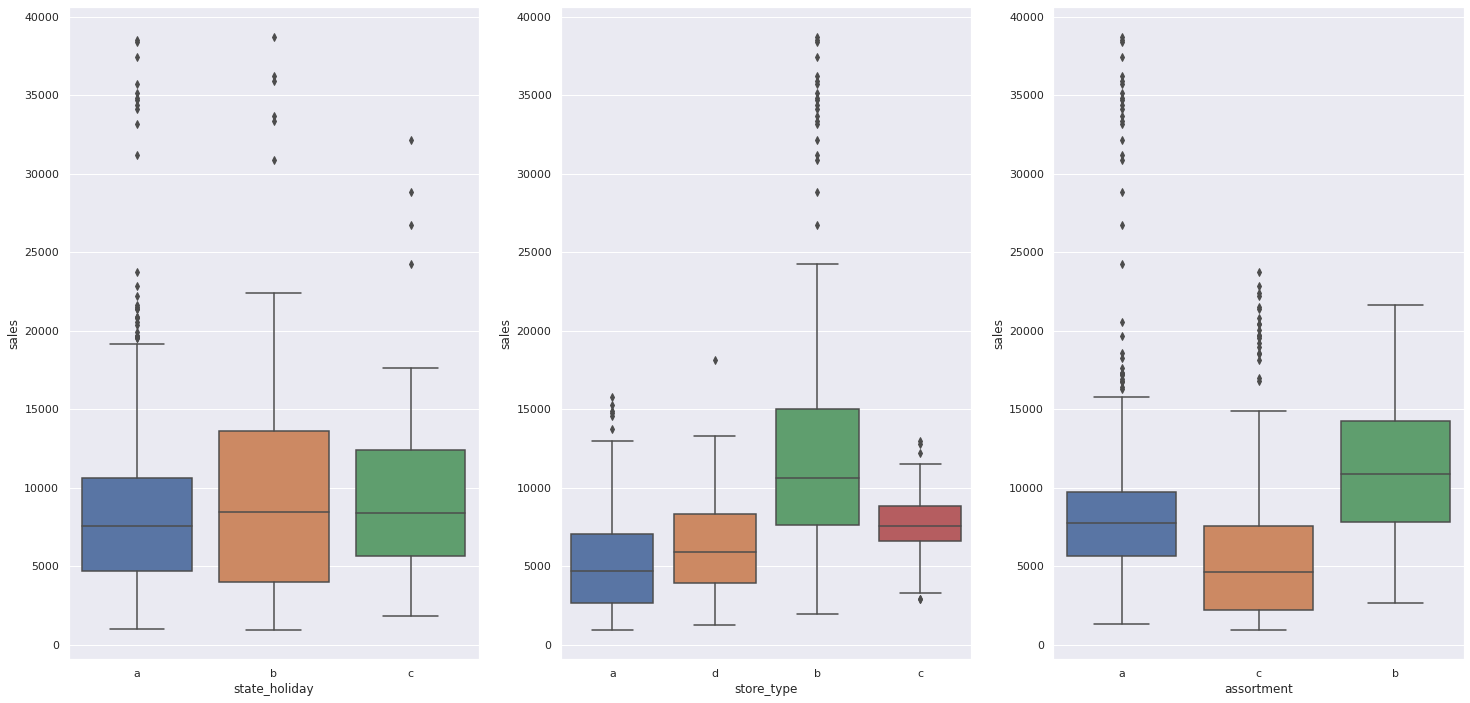

In [16]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

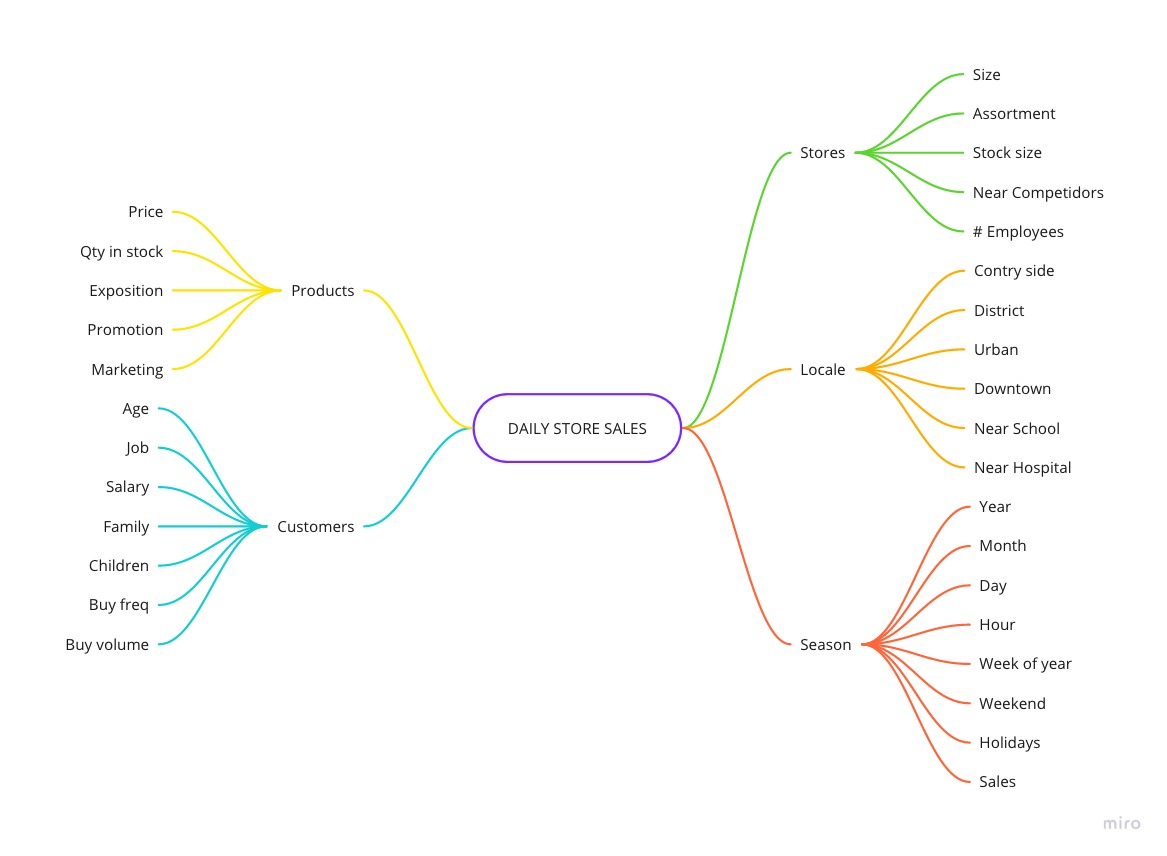

In [18]:
Image('hypothesis_map.png')

## 2.2. Creation of Hypotheses

### 2.2.1 Store Hypotheses

**1.** Stores with more employees should sell more

**2.** Stores with more stocks capacity should sell more.

**3.** Biggest stores should shell more.

**4.** Stores with biggest assortment should sell more.

**5.** Stores with closest competitors should sell less.

**6.** Stores with longer competitors should sell more. 

### 2.2.2 Product Hypotheses

**1.** Stores with more marketing investiment should sell more.

**2.** Stores with more product exposion should sell more.

**3.** Stores with lower product prices should sell more.

**4.** Stores with more agressive promotions (highest discounts) should sell more.

**5.** Stores with longest promotions should sell more. 

**6.** Stores with more promotions days should sell more.

**7.** Stores with consecutive promotions should sell more.

### 2.2.3 Time Hypotheses

**1.** Stores opened in christmas holiday should sell more.

**2.** Stores should sell more in the second semester of the year.

**3.** Stores should sell more after day 10 of each month.

**4.** Stores should sell more in the weekends.

**5.** Stores should sell more in the scholl holidays.

## 2.3. Final Hypotheses List

**1.** Stores with biggest assortment should sell more.

**2.** Stores with closest competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with longest promotions should sell more.

**5.** Stores with more promotions days should sell more.

**6.** Stores with consecutive promotions should sell more.

**7.** Stores opened in christmas holiday should sell more.

**8.** Stores with more product exposion should sell more.

**9.** Stores should sell more in the second semester of the year.

**10.** Stores should sell more after day 10 of each month.

**11.** Stores should sell more in the weekends.

**12.** Stores should sell more in the scholl holidays.

## 2.4 Feature Engineering

In [19]:
# year 
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/ 30).apply(lambda x: x.days).astype(int)

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [20]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable Filtering

In [22]:
df3 = df2.copy()

## 3.1 Line Filtering 

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Column Selection 

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [25]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis

In [26]:
df4 = df3.copy()

## 4.1 univariate analysis

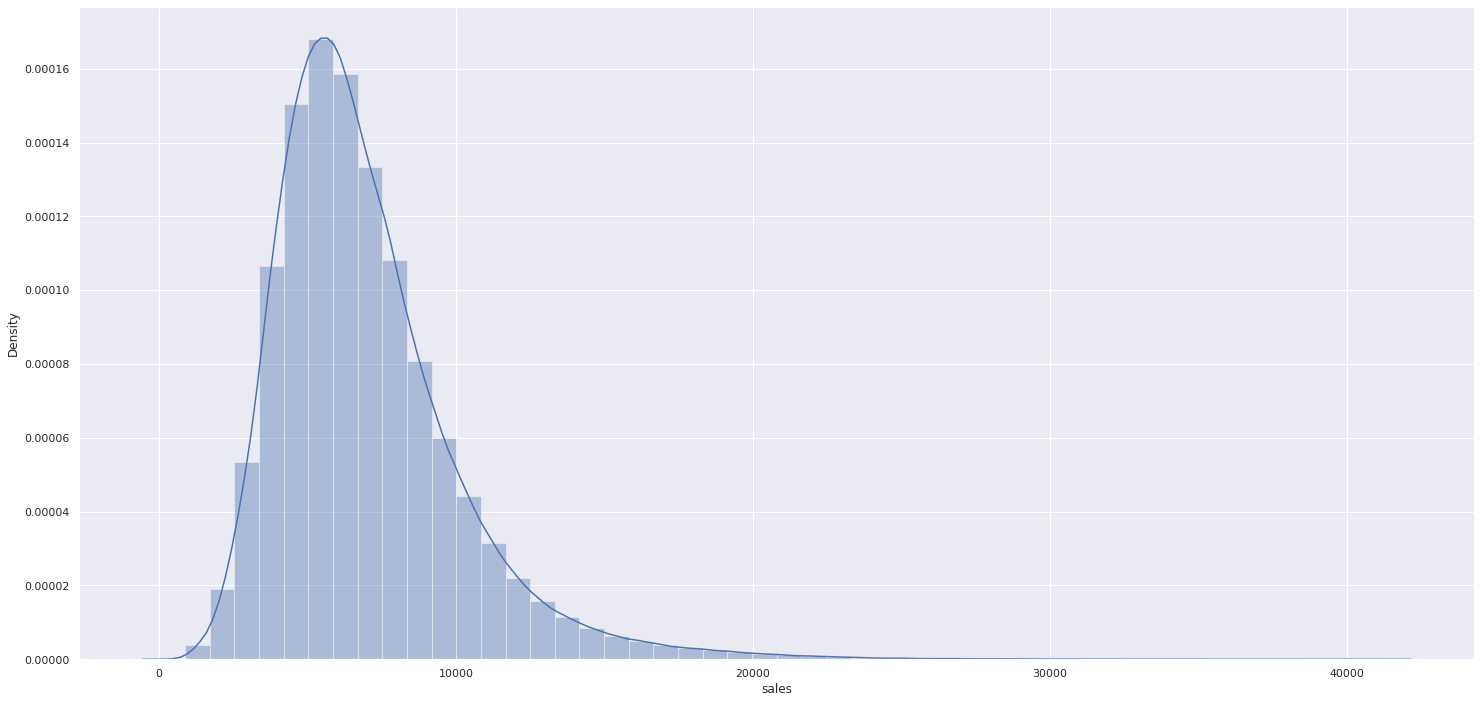

In [27]:
#Plotando a distribuição dos dados das vendas 
sns.distplot(df4['sales']);

#para gerar apenas o histograma 
#sns.distplot(df4['sales'], kde=False)

#método para aplicar o skew para o lado direito 
#sns.distplot(np.log1p((df4['sales'])))

## 4.1.2 Numerical Variable

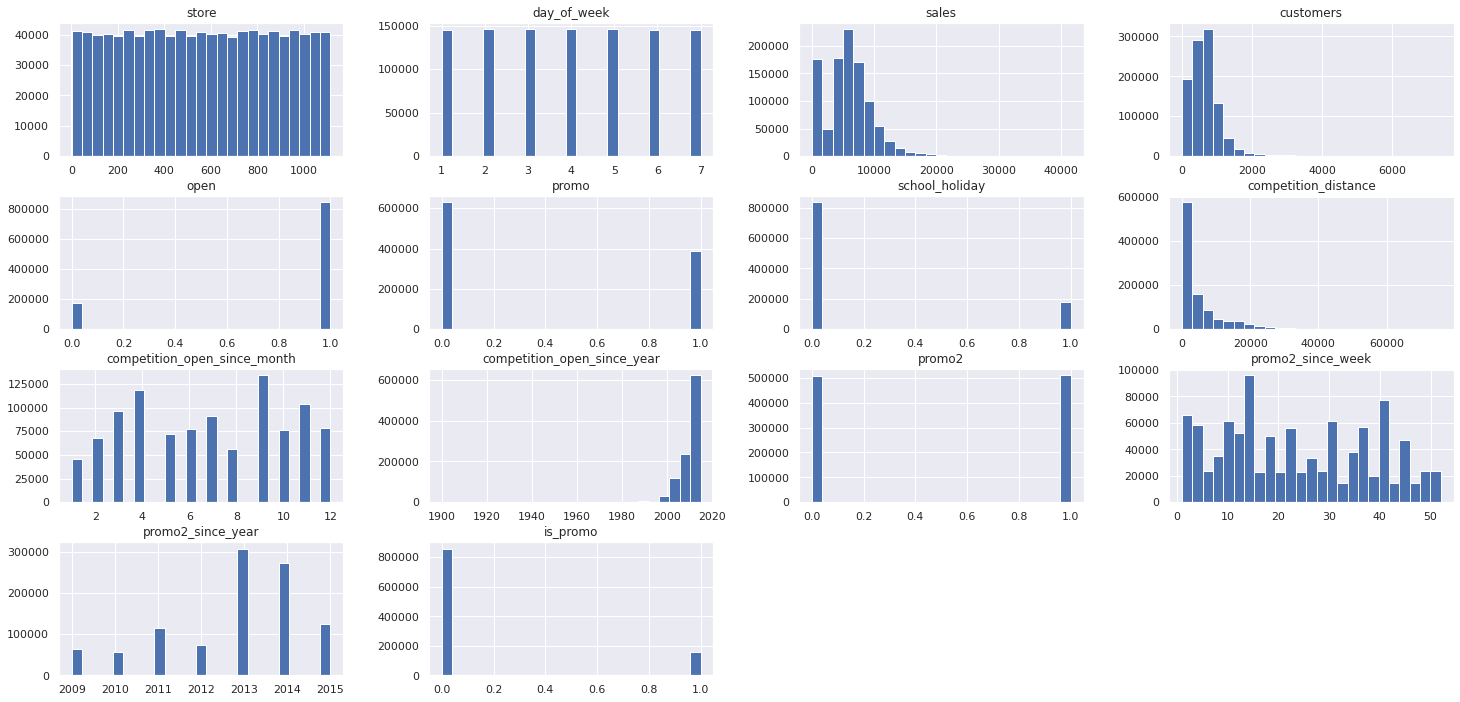

In [28]:
#plotando todos os gráficas da variável numérica 
num_attributes.hist(bins=25);

## 4.1.3 Categorical Variable

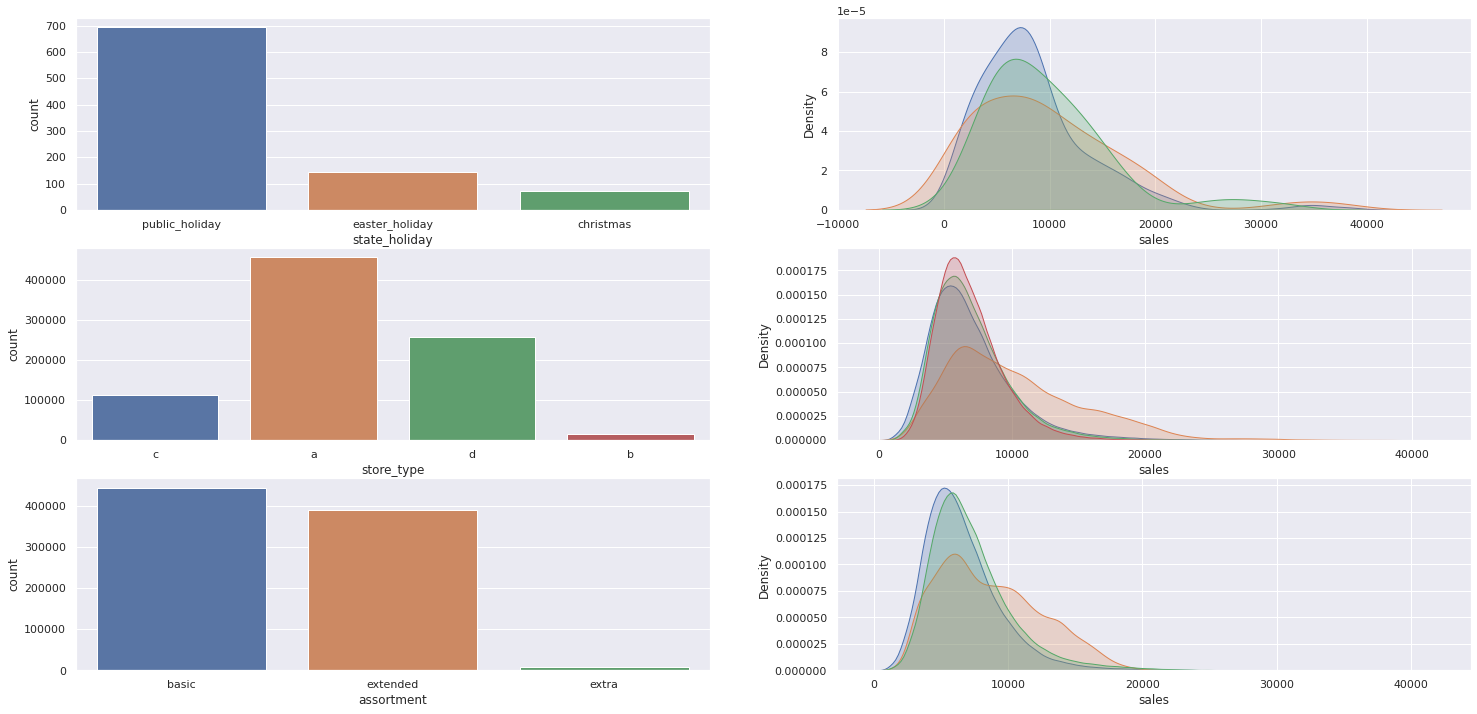

In [29]:
#Analisando os 3 primeiros atributos categóricos
cat_attributes.head()

#dropando as informações duplicadas 
df4['state_holiday'].drop_duplicates()

#state holiday
#usando comando para plottar mais de um gráfico 
#3 linhas, 2 colunas, grafico 1
plt.subplot(3,2,1)

#filtrando state_holiday para tirar os dias normais 
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

#3 linhas, 2 colunas, grafico 2
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday', shade='True');
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday', shade='True');
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas', shade='True');


#store_type
#3 linhas, 2 colunas, grafico 3
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

#3 linhas, 2 colunas, grafico 4
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a', shade='True');
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b', shade='True');
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c', shade='True');
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d', shade='True');

#assortment
#3 linhas, 2 colunas, grafico 5
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

#3 linhas, 2 colunas, grafico 6
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label='basic', shade='True');
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra', shade='True');
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label='extended', shade='True');

## 4.0 Bivariate Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais.

**Falsa:** Lojas com maior sortimento vendem menos

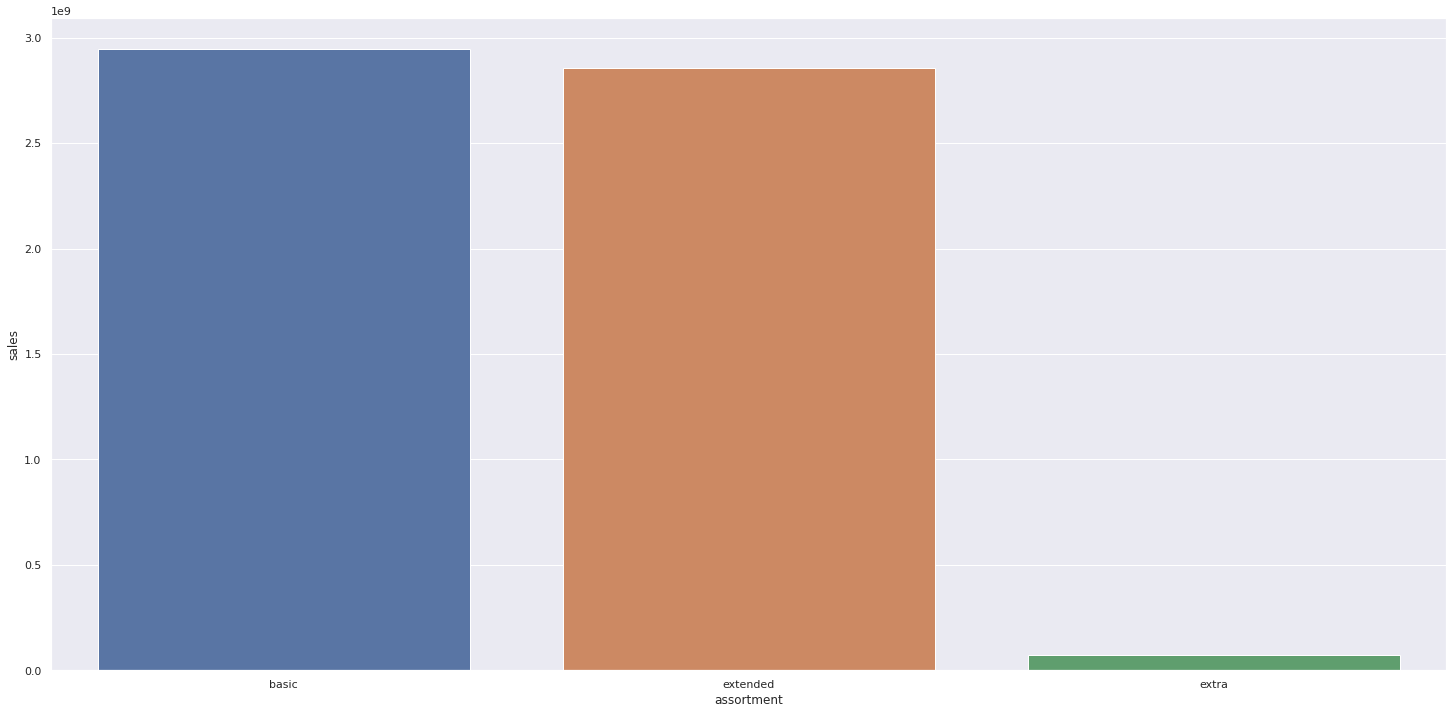

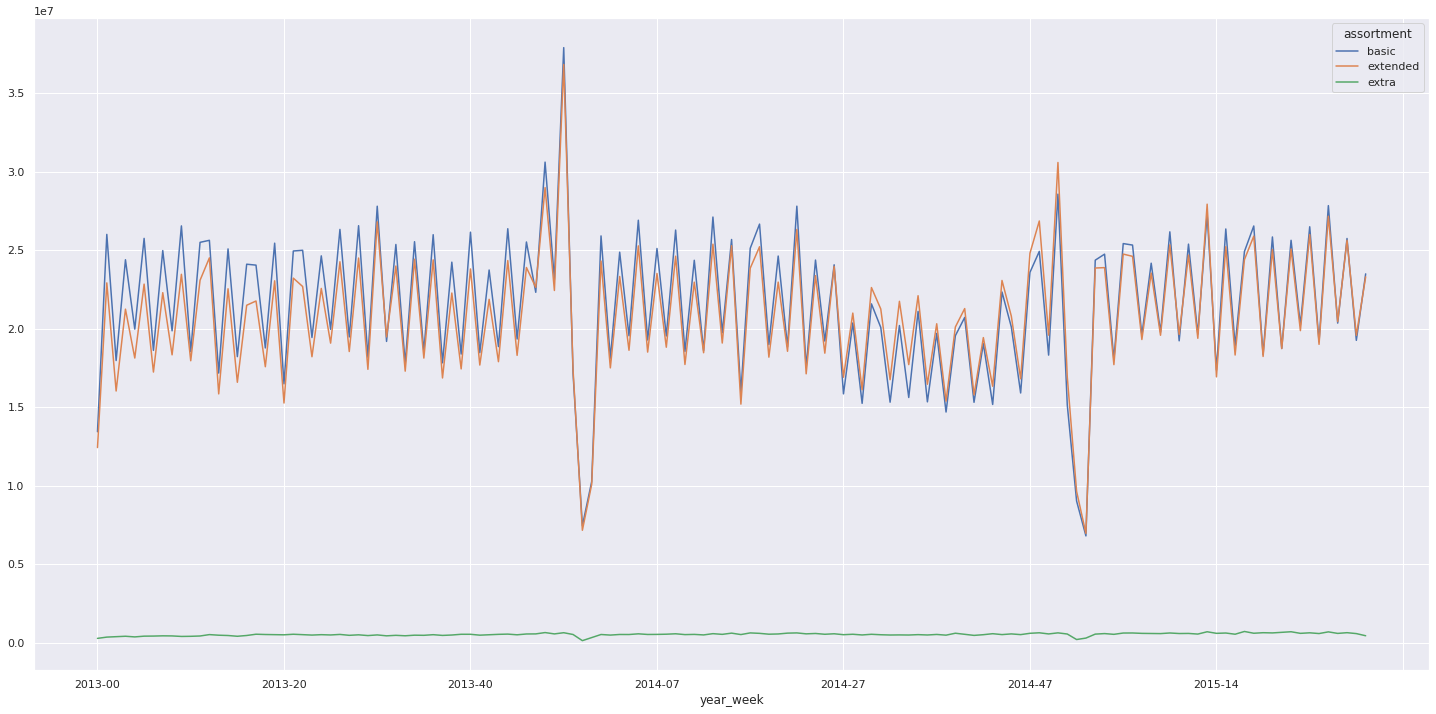

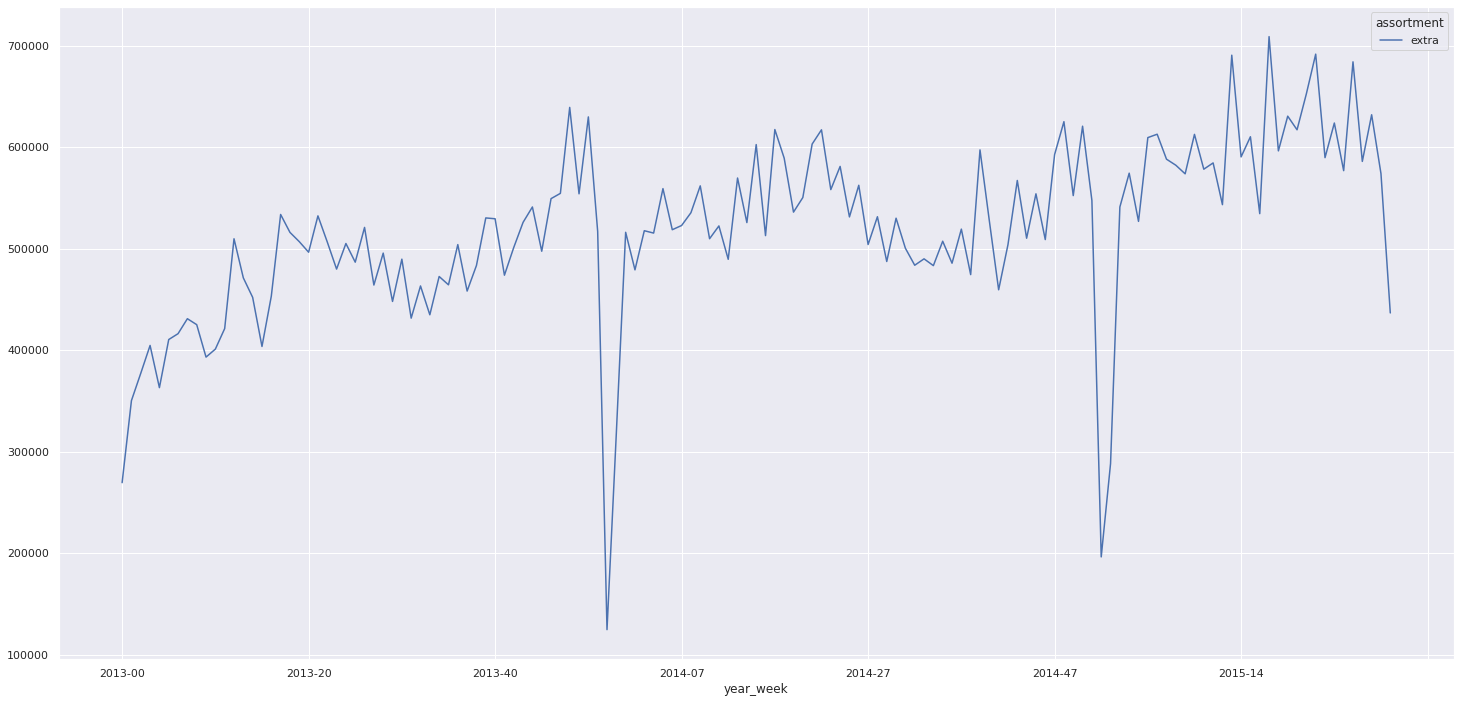

In [30]:
#agrupando todas as vendas por assortment 
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
#plotando o gráfico com as vendas por assortment 
sns.barplot(x='assortment', y='sales', data=aux1);

#agrupando todas as vendas por assortment e semanas do ano 
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
#fazendo a plotagem do gráfico com as vendas por assortment pelas semanas do ano 
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

#filtrando as vendas somente pelo assortment extra
aux3 = aux2[aux2['assortment'] == 'extra']
#criando um pivot para inverter as informações
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.**  Lojas com competidores mais próximos vendem menos.

**Falso:** Lojas com competidores mais próximos vendem mais

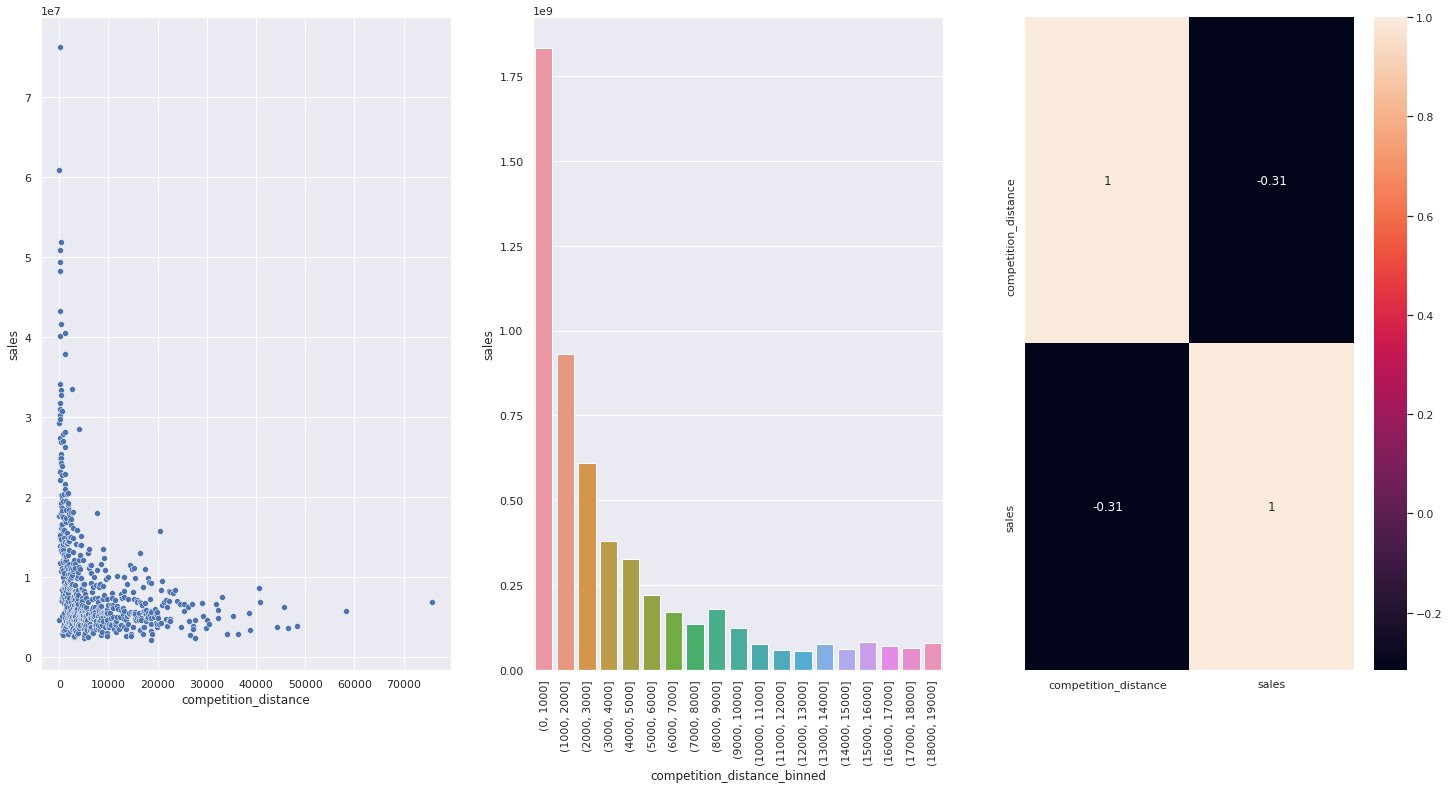

In [31]:
#agrupando todas as vendas pela distancia dos outros competidores até a nossa loja 
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#criando um conjunto de gráficos, com 1 linha e e 3 colunas 
#gráfico na posição 1 
plt.subplot(1,3,1)
#plotagem usando os pontos para visualizar melhor o comportamento dos dados
#o ';' no final da linha serve para evitar as mensagens de plottagem  
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

#gráfico na posição 2 
plt.subplot(1,3,2)
#criando grupos de 1k em 1k até 20k para agrupar as lojas de 1000 em mil metros em um único grupo 
bins = list(np.arange(0, 20000, 1000))
#aplicando os grupos de 1k em 1k na variavel 'competition_distance_binned'
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
#agrupando as vendas pela distancia da loja 
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
#fazendo a plotagem do gráfico com os grupos de 1k em 1k 
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
#rodando as legendas do eixo 'x' para melhor visualização 
plt.xticks(rotation = 90);

#gráfico na posição 3
plt.subplot(1,3,3)
#criando um heatmap para verificar a correlação entre a distancia e a quantidade de vendas 
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores a mais tempo vendem mais

**Falsa:** Lojas com competidores a mais tempo vendem menos

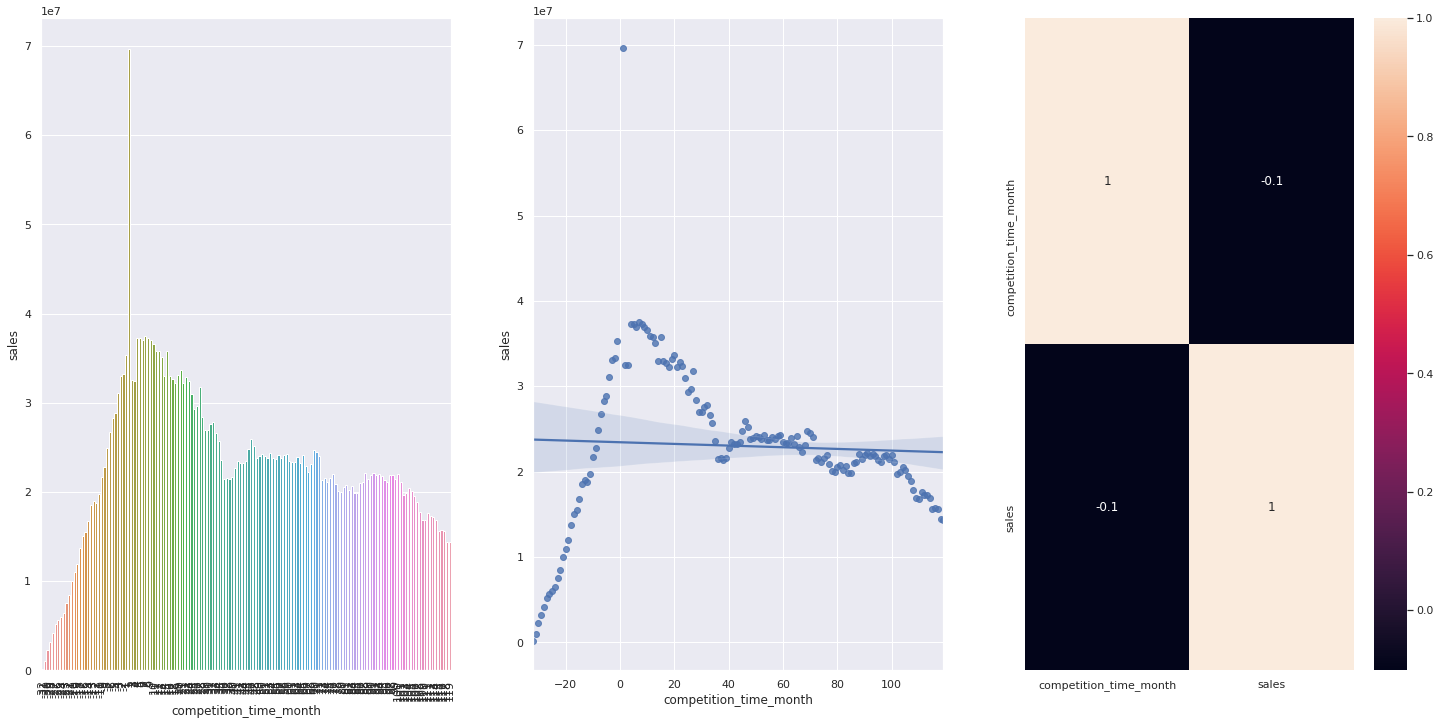

In [32]:
#criando lista com 1 linha 3 3 colunas 
#plot na posição 1 
plt.subplot(1,3,1)

#verificando a quantidade de vendas por meses 
#criando filtro de vendas por meses desde a abertura das lojas proximas 
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
#fazendo filtro com lojas com menos de 120 meses desde a abertura de outras lojas 
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
#fazendo a plotagem com a variavel filtrada 
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

#plot na posição 2
plt.subplot(1,3,2)

#fazendo a plotagem da tendência dos dados
sns.regplot(x='competition_time_month', y='sales', data=aux2);

#posição 3 
plt.subplot(1,3,3)
#gerando heatmap
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falsa:** Lojas com promoções a mais tempo vendem menos, depois de um certo período

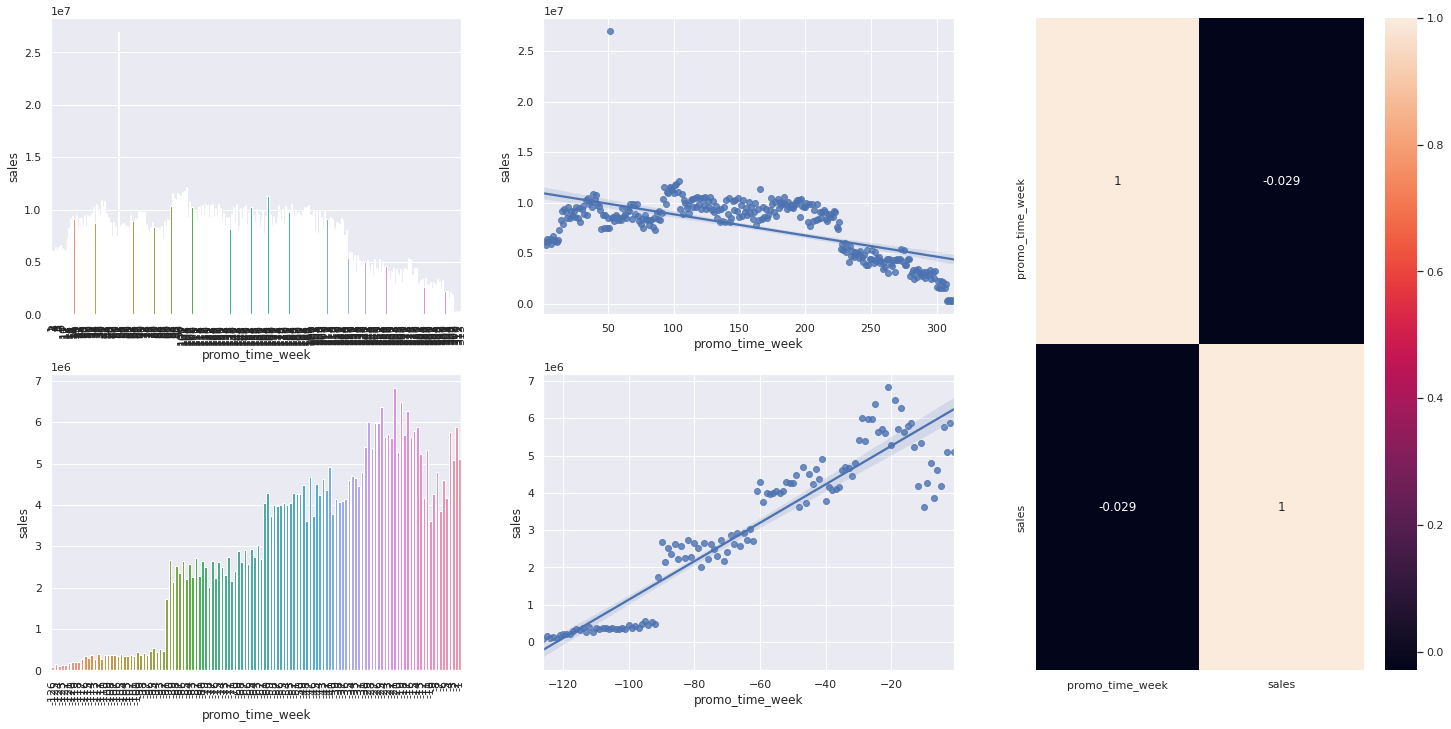

In [33]:
#gerando variavel para comparação das colunas 
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

#criando um 'subplot' unindo as duas linhas da última coluna para ser usado como um gráfico só 
grid = GridSpec(2, 3)

#linha 0 coluna 0
plt.subplot(grid[0,0])

#filtrando a promoção como 'promoção extendida'
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção extendida
#plotando o gráfico de promoções extendidas 
sns.barplot(x='promo_time_week', y='sales', data=aux2);
#girando as legendas em 90 graus 
plt.xticks(rotation=90);

#coluna 0 linha 1 
plt.subplot(grid[0,1])
#plotando o gráfico da têndencia de vendas do primeiro gráfico 
sns.regplot(x='promo_time_week', y='sales',data=aux2);

#coluna 1 linha 0 
plt.subplot(grid[1,0])

#filtrando a promoção por 'promoção normal '
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção normal

#plotandoo o gráfico de vendas durante a promoção normal 
sns.barplot(x='promo_time_week', y='sales', data=aux3);
#girando as legendas em 90 graus
plt.xticks(rotation=90);

#coluna 1 linha 1 
plt.subplot(grid[1,1])
#plotando o gráfico da têndencia de vendas do segundo gráfico 
sns.regplot(x='promo_time_week', y='sales', data=aux3);

#todas as linhas da última coluna
plt.subplot(grid[:,2])
#plotando o heatmap da variavel 'aux1' para ver a correlação entre as variaveis 
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H6.** Lojas com promoções consecutivas vendem mais

**Falsa:** Lojas com promoções consecutivas vendem menos

In [34]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


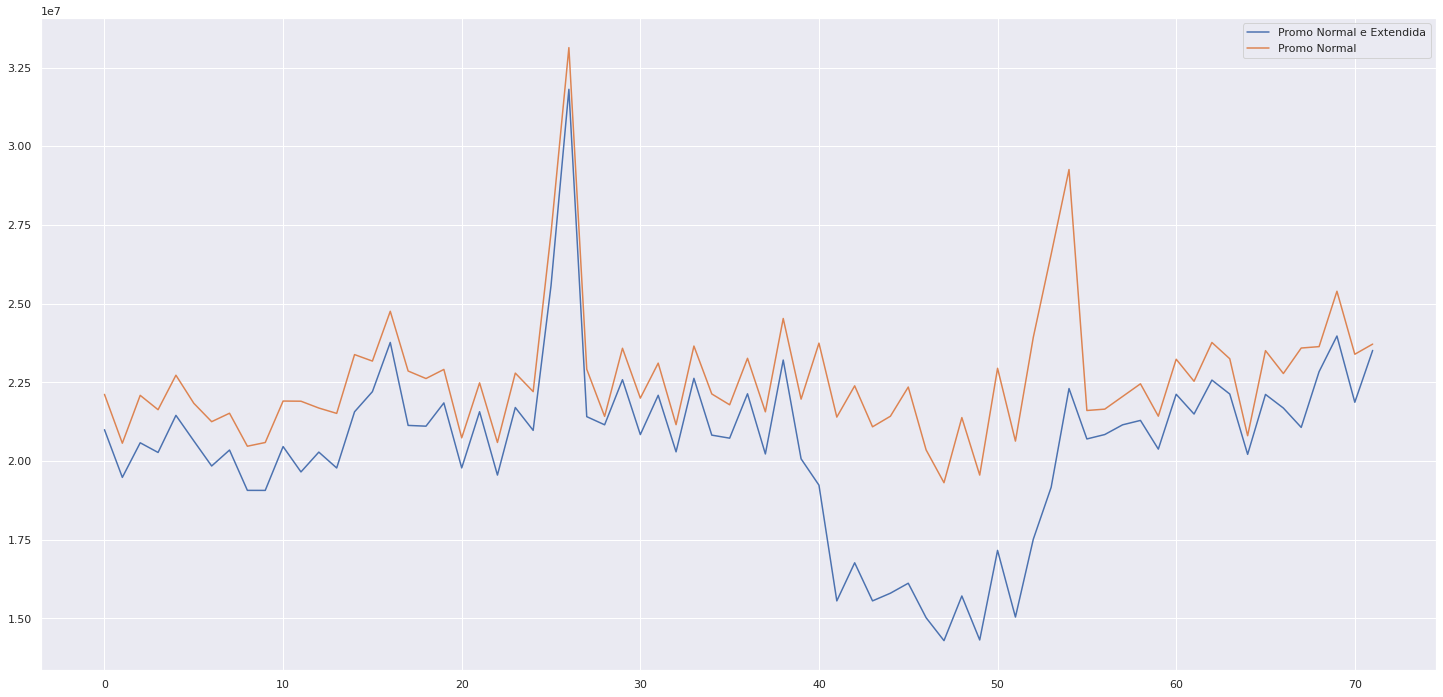

In [35]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);
plt.legend(['Promo Normal e Extendida', 'Promo Normal']);

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**Falsa:** Lojas abertas durante o feriado de natal não vendem mais.

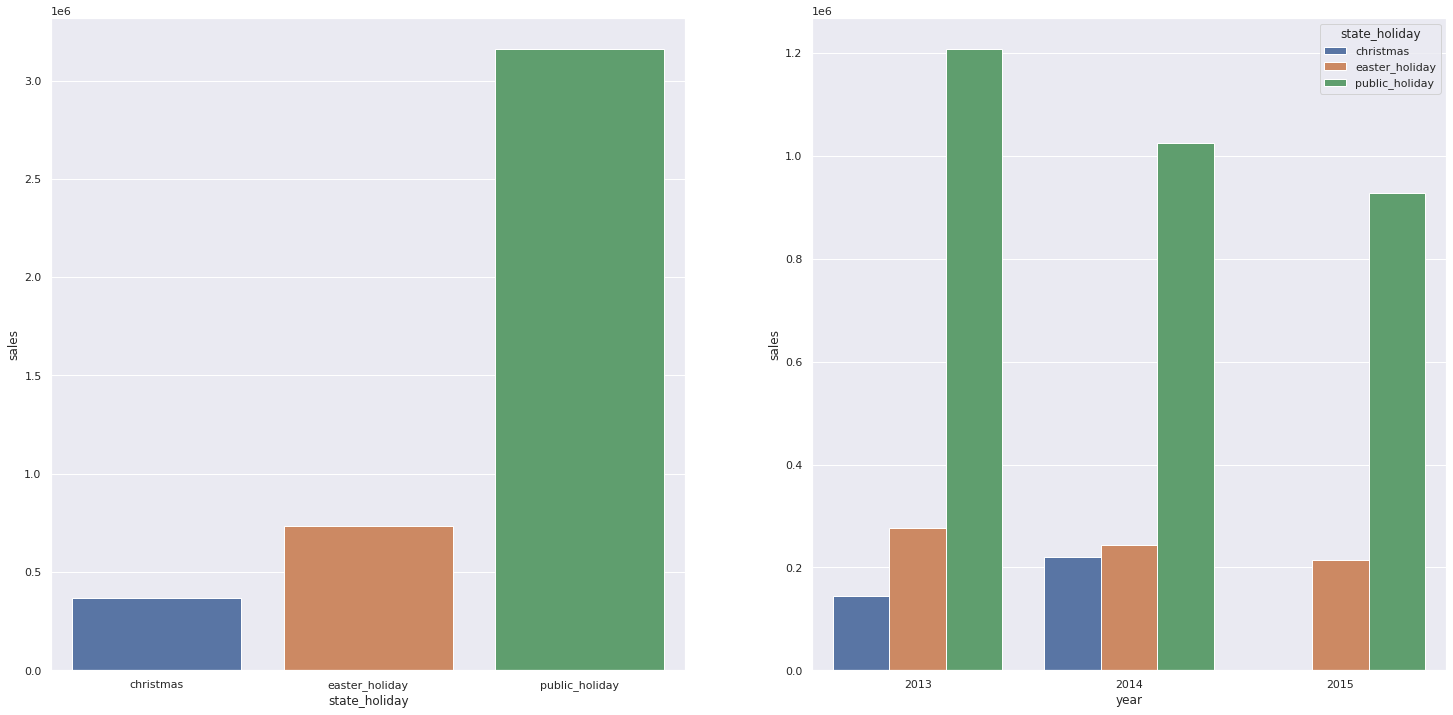

In [36]:
#criando filtro para tirar os dias regulares 
aux = df4[(df4['state_holiday'] != 'regular_day') & (df4['sales'])]

#linha 1 coluna 1  
plt.subplot(1,2,1)

#agrupando as vendas pelos feriados
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
#plotando gráfico de vendas por feriados 
sns.barplot(x='state_holiday', y='sales', data=aux1);

#linha 1 coluna 2
plt.subplot(1,2,2)

#agrupando as vendas por feriados através dos anos 
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
#plotando gráfico de vendas por feriados através dos anos 
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos
**Falsa:** Lojas vendem menos ao longo dos anos

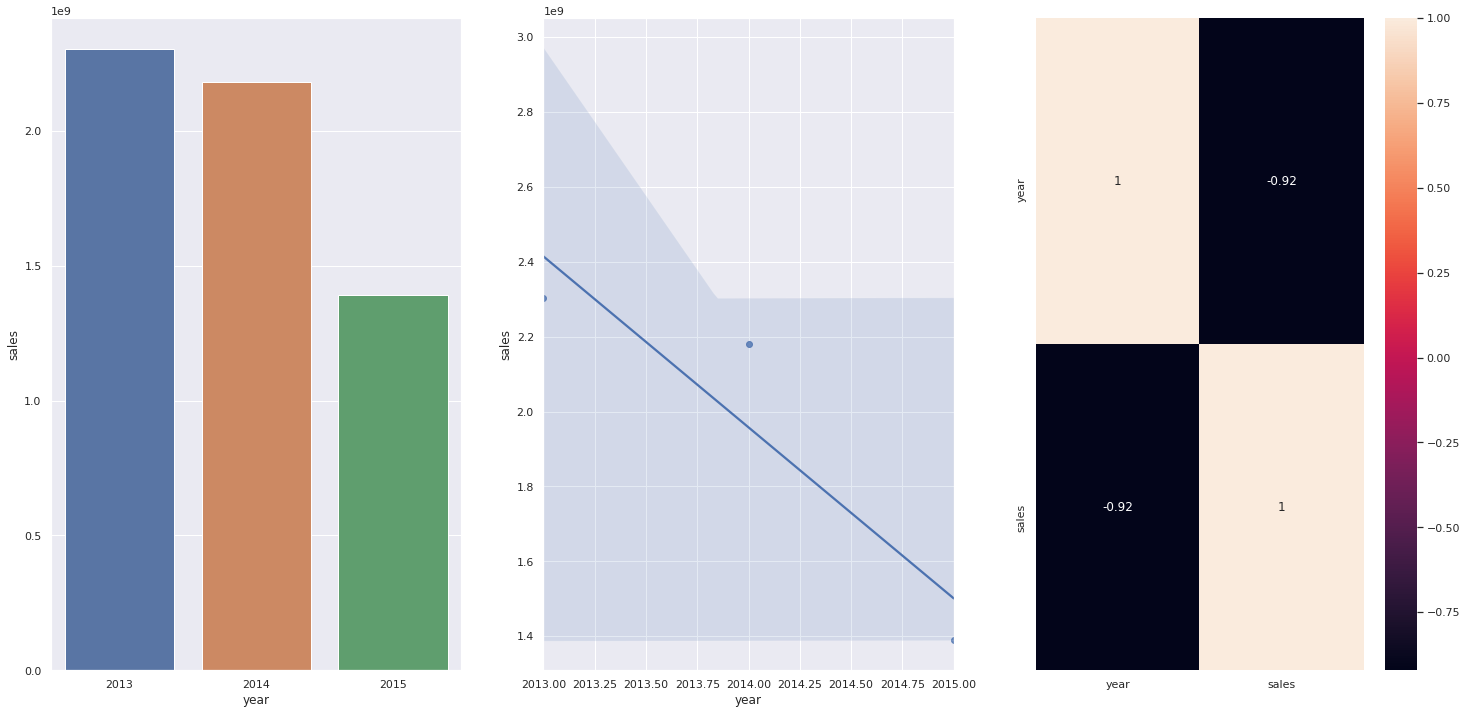

In [37]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano

**Falsa:** As lojas vendem menos no segundo semestre do ano

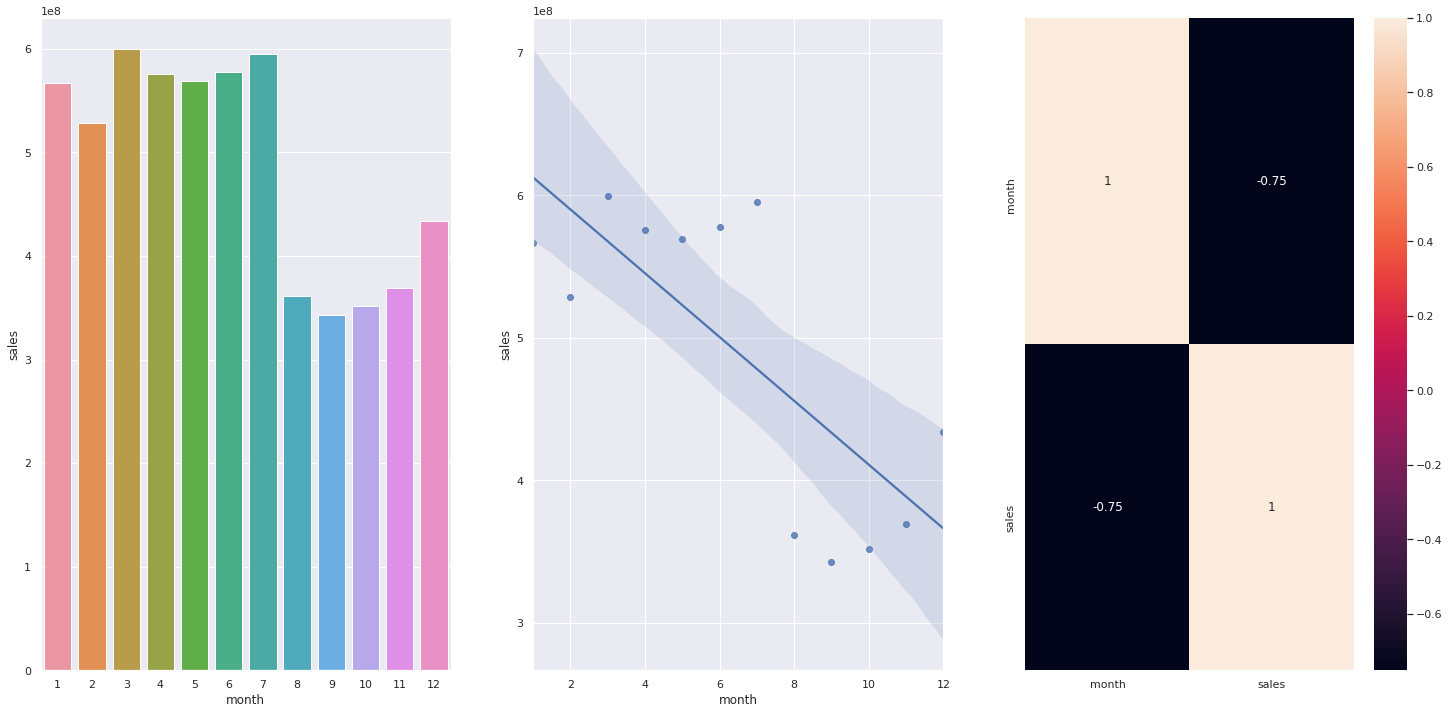

In [38]:
#criando variavel com as vendas por mês 
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

#linha 1, coluna 1, posição 1
plt.subplot(1,3,1)
#plotando as vendas por meses 
sns.barplot(x='month', y='sales', data=aux1);

#linha 1, coluna 1, posição 2
plt.subplot(1,3,2)
#plotando a tendência das vendas por meses 
sns.regplot(x='month', y='sales', data=aux1);

#linha 1, coluna 1, posição 3
plt.subplot(1,3,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**Verdadeira:** As lojas vendem mais depois do dia 10 de cada mês

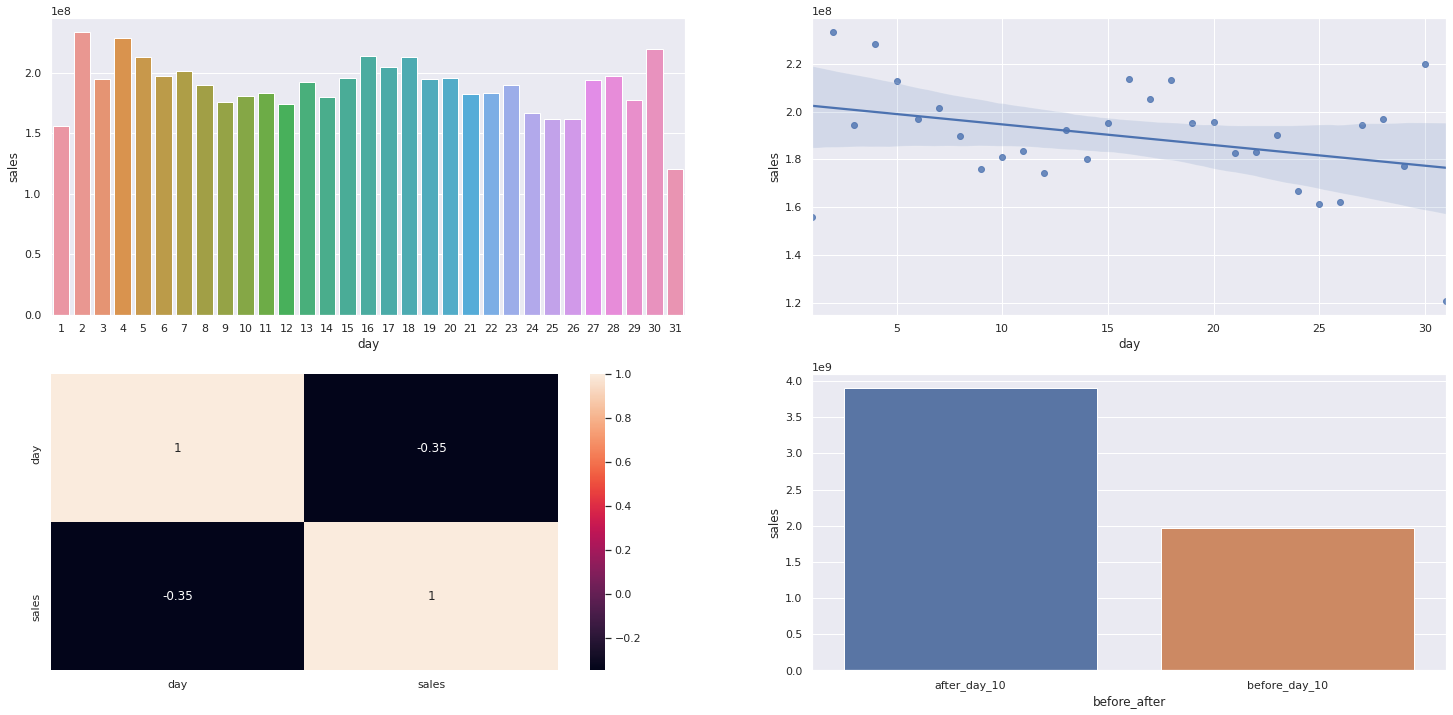

In [39]:
#criando variavel com as vendas por dias 
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

#linha 1, coluna 1
plt.subplot(2,2,1)
#plotando as vendas por dias 
sns.barplot(x='day', y='sales', data=aux1);

#linha 1, coluna 2
plt.subplot(2,2,2)
#plotando a tendência das vendas por dias 
sns.regplot(x='day', y='sales', data=aux1);

#linha 2, coluna 1
plt.subplot(2,2,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

#linha 2, coluna 2 
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos ao finais de semana

**Verdadeiro:** Lojas vendem menos aos finais de semana

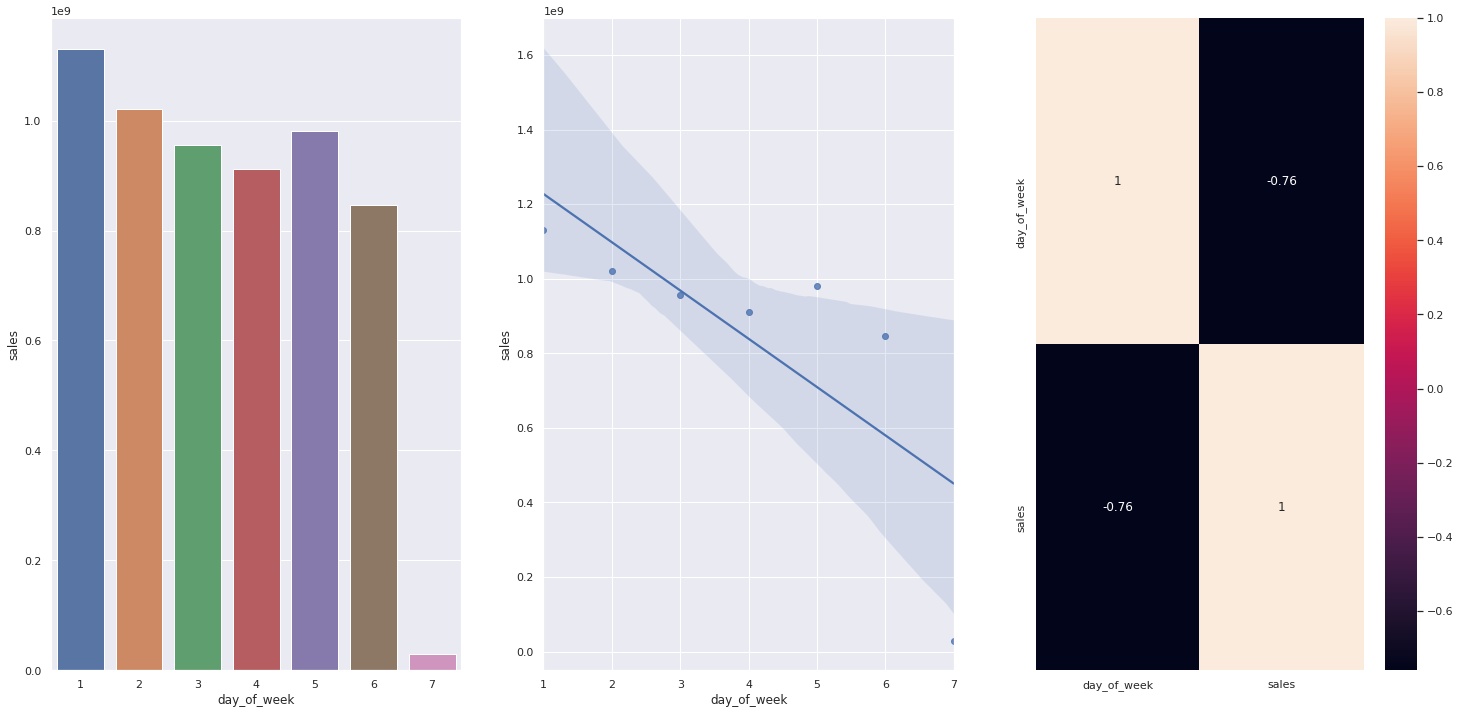

In [40]:

#criando variavel com as vendas por dias da semana  
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

#linha 1, coluna 1
plt.subplot(1,3,1)

#plotando as vendas por dias da semana 
sns.barplot(x='day_of_week', y='sales', data=aux1);

#linha 1, coluna 2
plt.subplot(1,3,2)

#plotando a tendência das vendas por dias da semana 
sns.regplot(x='day_of_week', y='sales', data=aux1);

#linha 1, coluna 3
plt.subplot(1,3,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares

**Verdadeiro:** As lojas vendem menos durante os feriados escolares, com exceção do mês de agosto

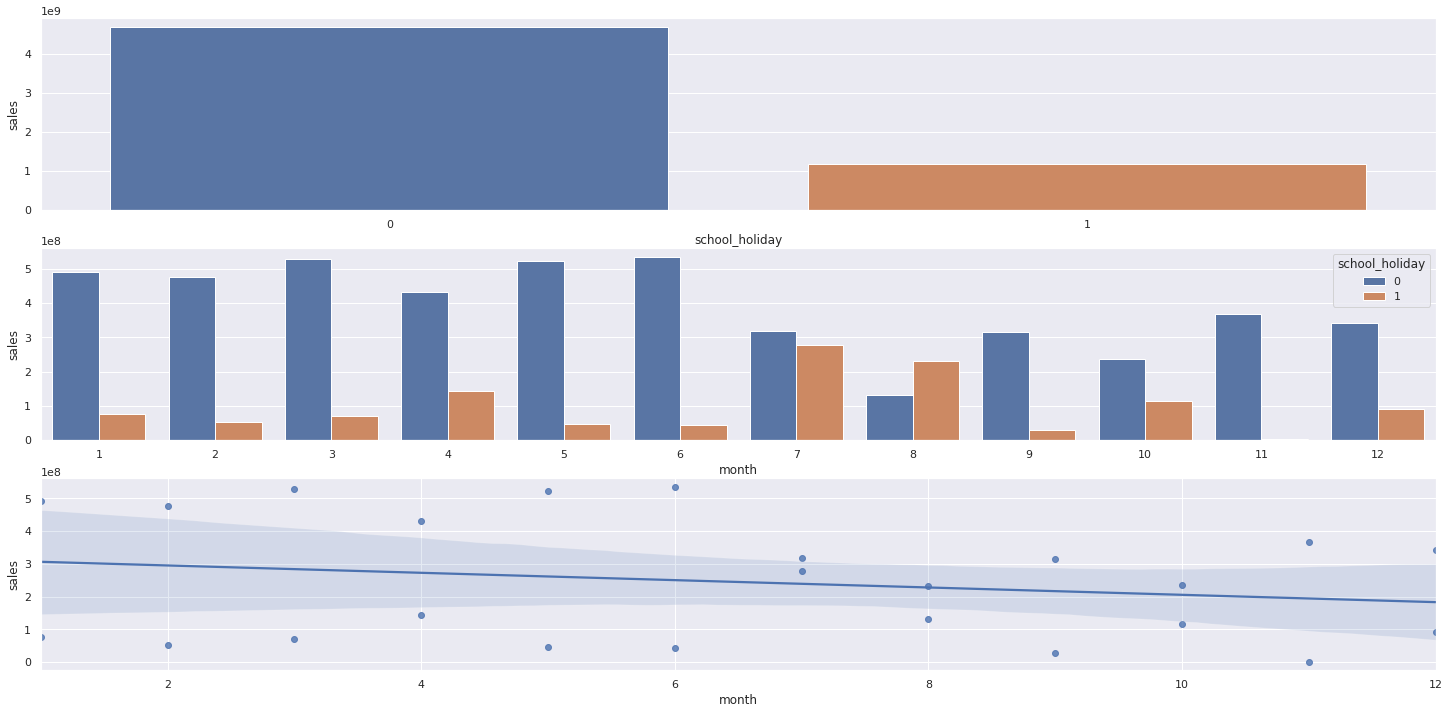

In [41]:
#criando variavel com as vendas por dias da semana  
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
#linha 1, coluna 1
plt.subplot(3,1,1)
#plotando as vendas por dias da semana 
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(3,1,2)
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2);

plt.subplot(3, 1, 3)
sns.regplot(x='month', y='sales', data=aux2);

### 4.1.2 Summary of Hypotheses

In [44]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

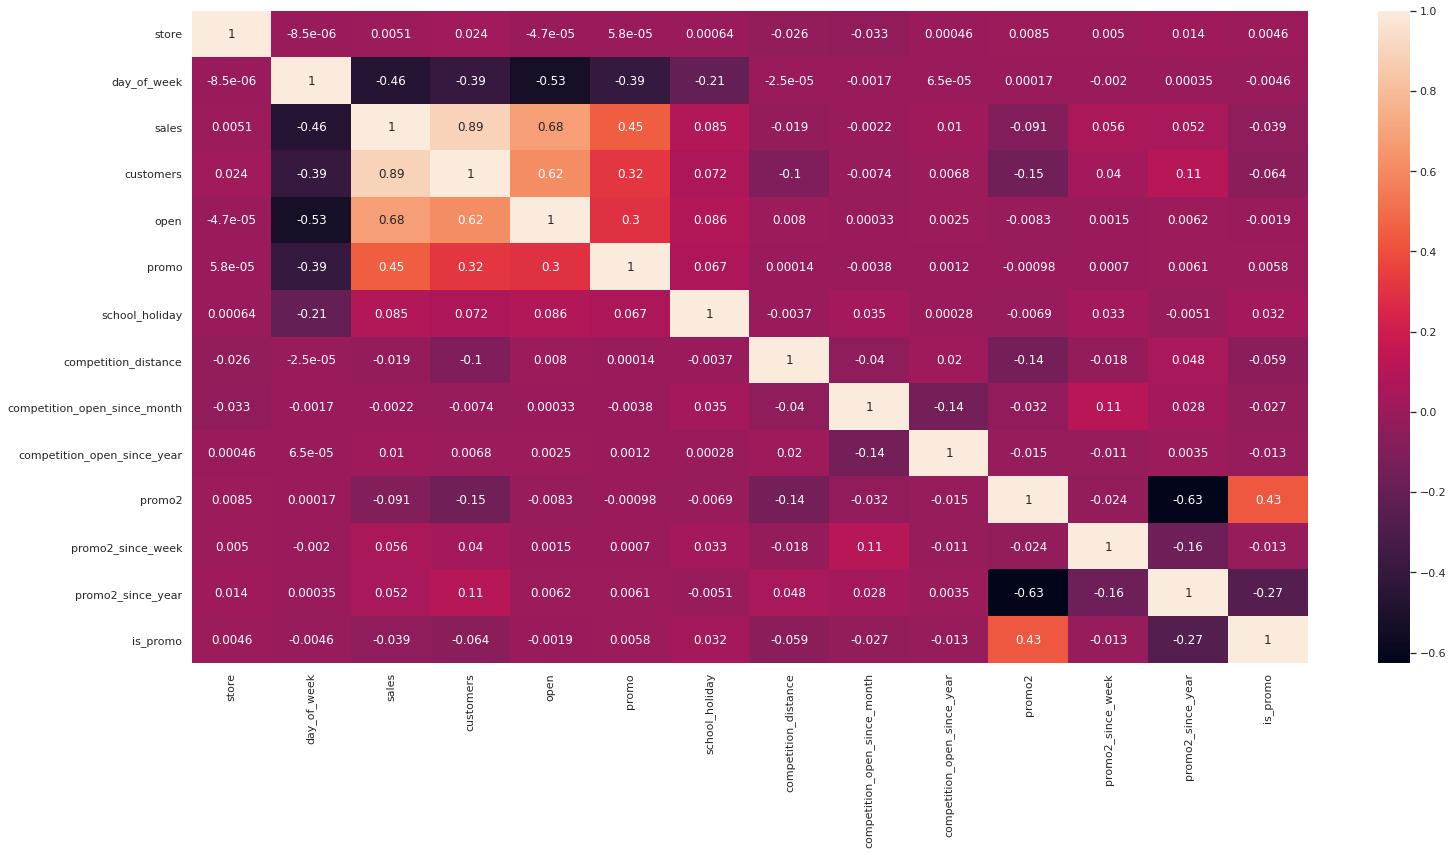

In [45]:
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True);

### 4.3.2 Categorical Attributes

In [46]:
a = df4.select_dtypes(include='object')

In [47]:
a1 = cramer_v(a['state_holiday'] ,a['state_holiday'] )
a2 = cramer_v(a['state_holiday'] ,a['store_type'] )
a3 = cramer_v(a['state_holiday'] ,a['assortment'] )

a4 = cramer_v(a['store_type'] ,a['state_holiday'] )
a5 = cramer_v(a['store_type'] ,a['store_type'] )
a6 = cramer_v(a['store_type'] ,a['assortment'] )

a7 = cramer_v(a['assortment'] ,a['state_holiday'] )
a8 = cramer_v(a['assortment'] ,a['store_type'] )
a9 = cramer_v(a['assortment'] ,a['assortment'] )

df = pd.DataFrame({'state_holiday':[a1, a2, a3],
                   'store_type':[a4, a5, a6],
                   'assortment':[a7, a8, a9]})
df = df.set_index(df.columns)

df

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


# 5.0 Data Preparation

In [48]:
df5 = df4.copy()

## 5.1 Normalization

In [49]:
# nenhum dado precisou ser normalizado nesse DF

## 5.2 Rescheduling

In [50]:
#Separando as variáveis númericas das demais variáveis 
a = df5.select_dtypes(include=['int64', 'float64'])

In [51]:
#precisamos verificar qual variável tem outlier para decidir qual scaling será aplicado 
#RobustScaler é aplicado quando há outlier na variável 
#MinMaxScaler é aplicado quando n]ao há outlier na variável 
robust = RobustScaler()
mms = MinMaxScaler()

#VARIÁVEIS NÃO CÍCLICAS 

#competition_distance 
df5['competition_distance'] = robust.fit_transform(df5[['competition_distance']].values)
pickle.dump(robust, open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition_time_month 
df5['competition_time_month'] = robust.fit_transform(df5[['competition_time_month']].values)
pickle.dump(robust, open('parameter/competition_time_month_scaler.pkl', 'wb'))

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [52]:
#state_holiday - One Hot Encoder(Dumming Encoding)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoder
LE = LabelEncoder()
df5['store_type'] = LE.fit_transform(df5['store_type'])
pickle.dump(LE, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformation of response variable

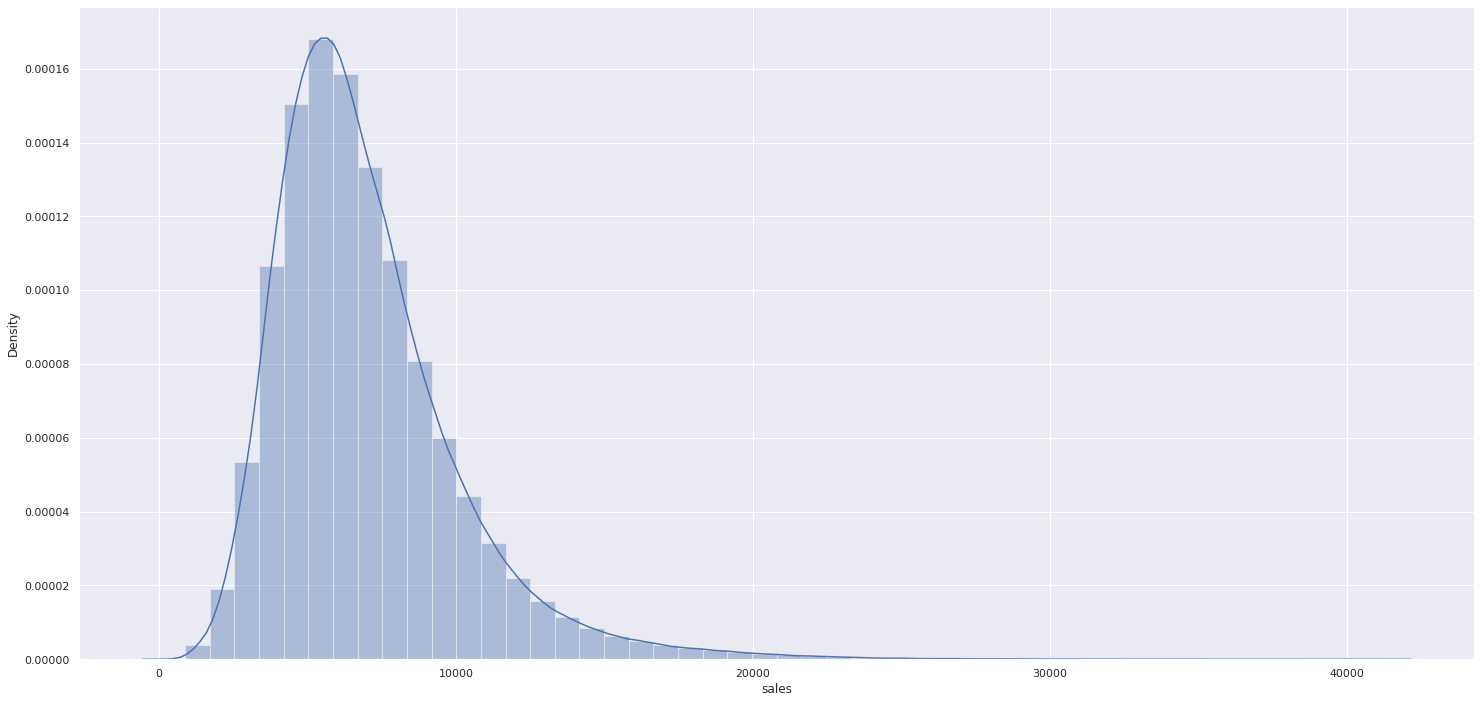

In [53]:
#plotando a distribuição dos dados
sns.distplot(df5['sales']);

In [54]:
#reescalando a variável resposta 
df5['sales'] = np.log1p(df5['sales'])

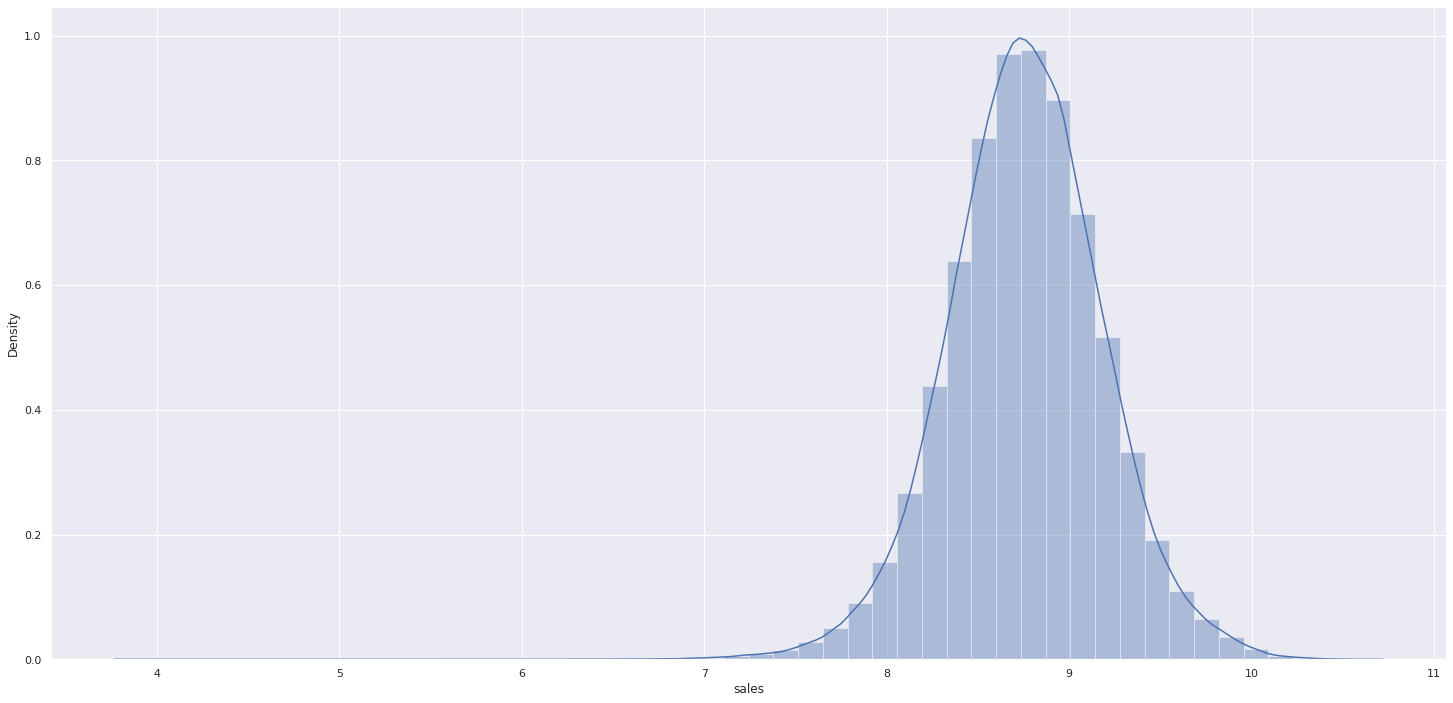

In [55]:
#plotando a distribuição dos dados
sns.distplot(df5['sales']);

### 5.3.3 Nature Transformation

In [56]:
#VARIÁVEIS CÍCLICAS 

#aplicando o seno e cosseno nas variáveis cíclicas, para fazer a transformação dos dados de categóricos(letras) para inteiros 

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2. * np.pi /30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2. * np.pi /30)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2. * np.pi /12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2. * np.pi /12)))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi /7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi /7)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi /52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi /52)))

# 6.0 Feature Selection

In [57]:
df6 = df5.copy()

## 6.1 Split Database into train and test

In [58]:
drop_cols = ['week_of_year', 'day_of_week', 'month', 'day', 'year_week', 'competition_since','promo_since']
df6 = df6.drop(drop_cols, axis=1)

In [59]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(6*7)

Timestamp('2015-06-19 00:00:00')

In [60]:
#criando base de dados de treino 
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#criando base de dados de teste 
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training min date in train base: {}'.format(X_train['date'].min()))
print('Training max date in train base: {}'.format(X_train['date'].max()))

print('\nTraining min date in test base: {}'.format(X_test['date'].min()))
print('Training max date in test base: {}'.format(X_test['date'].max()))

Training min date in train base: 2013-01-01 00:00:00
Training max date in train base: 2015-06-18 00:00:00

Training min date in test base: 2015-06-19 00:00:00
Training max date in test base: 2015-07-31 00:00:00


## 6.2 Boruta as Attribute Selector

Boruta results alredy saved inside variable

In [61]:
'''ajustando as variáveis de treino e teste para que possam ser aplicadas no boruta 

x_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = Y_train.values.ravel()

#defirindo parametros do algoritmo random forest 
rf = RandomForestRegressor(n_jobs = -1)

#definindo parametros do boruta 
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0).fit(x_train_n, y_train_n)'''

"ajustando as variáveis de treino e teste para que possam ser aplicadas no boruta \n\nx_train_n = X_train.drop(['date', 'sales'], axis=1).values\ny_train_n = Y_train.values.ravel()\n\n#defirindo parametros do algoritmo random forest \nrf = RandomForestRegressor(n_jobs = -1)\n\n#definindo parametros do boruta \nboruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0).fit(x_train_n, y_train_n)"

### 6.2.1 Best Attributes According to Boruta

In [62]:
'''criando uma lista com as colunas que foram selecionadas pelo boruta 
cols_selected = boruta.support_.tolist()

#criando variável para localizar as colunas que foram selecionadas 
# VERIFICAR SE ESSAS COLUNAS AINDA ESTÃO NO DF E TIRA-LAS CASO ESTEJAM 'customers', 'open'
x_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

#verificando colunas não selecionadas 
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))'''

"criando uma lista com as colunas que foram selecionadas pelo boruta \ncols_selected = boruta.support_.tolist()\n\n#criando variável para localizar as colunas que foram selecionadas \n# VERIFICAR SE ESSAS COLUNAS AINDA ESTÃO NO DF E TIRA-LAS CASO ESTEJAM 'customers', 'open'\nx_train_fs = X_train.drop(['date', 'sales'], axis=1)\ncols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()\n\n#verificando colunas não selecionadas \ncols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))"

## 6.3 Manual Attributes Selector

**Boruta results already saved here**

In [63]:
cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                        'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                        'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin',
                        'week_of_year_cos']

cols_not_selected_boruta = ['is_promo','open','school_holiday','state_holiday_christmas','state_holiday_easter_holiday',
                            'state_holiday_public_holiday','state_holiday_regular_day','year']

#colunas para adiciona 
feat_to_add = ['date', 'sales']

#atributos finais 
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [64]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
x_training = X_train[cols_selected_boruta_full]

## 7.1 Model Average 

In [65]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# predição 
#agrupando as vendas por loja e tirando a média dos valores e salvando em uma nova variável 
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
#juntando o aux2 no aux1 pea coluna 'store'
aux1 = pd.merge(aux1, aux2, how='left', on='store')
#criando coluna com os valores de predição que nada mais são do que os valores das vendas, para poder em seguida tirar as médias de vendas
yhat_baseline = aux1['predictions']

#performance 
#criando variável com o valor do erro para o algoritmo de 'média de modelo'
baseline_result = ml_error('Average Model', Y_test, yhat_baseline)
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


# 7.2 Linear Regression Model

In [66]:
#modelo 
lr = LinearRegression().fit(x_train, Y_train)

#predição 
yhat_lr = lr.predict(x_test)

#performance 
lr_error = ml_error('Linear Regression model', np.expm1(Y_test), np.expm1(yhat_lr))
lr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression model,1872.732415,0.293623,2672.750712


### 7.2.1 Linear Regression Model - Cross Validation

In [67]:
lr_result_cv = cross_validation(x_training, 5, 'Croos Validation', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Croos Validation,1962.57 +/- 11.44,0.31 +/- 0.0,2810.34 +/- 16.25


## 7.3 Linear Regression Model Regularized - Lasso

In [68]:
#modelo 
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

#predição 
yhat_lrr = lrr.predict(x_test)

#performance 
lrr_error = ml_error('Linear Regression regularized model - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression regularized model - Lasso,1894.226401,0.289464,2745.812463


### 7.3.1 Linear Regression Model Regularized Lasso - Cross Validation

In [69]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1983.57 +/- 12.71,0.31 +/- 0.0,2856.5 +/- 17.93


## 7.4 Random Forest Regressor

In [70]:
'''#modelo 
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0).fit(x_train, Y_train)

#predição 
yhat_rf = rf.predict(x_test)

#performance 
rf_error = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_error'''

"#modelo \nrf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0).fit(x_train, Y_train)\n\n#predição \nyhat_rf = rf.predict(x_test)\n\n#performance \nrf_error = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))\nrf_error"

### 7.4.1 Random Forest Regressor - Cross Validation

In [71]:
'''rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv'''

"rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)\nrf_result_cv"

## 7.5 XGBoost Regressor

In [72]:
'''#modelo 
xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.01, max_depth=10, subsample=0.7, colsample_bytee=0.9).fit(x_train, Y_train)

#predição 
yhat_xgb = xgb.predict(x_test)

#performance 
xgb_error = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_error'''

[22:32:55] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.443295,0.94947,7330.611616


### 7.5.1 XGBoost Regressor - Cross Validation

In [73]:
'''xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', xgb, verbose=True)
xgb_result_cv'''


KFold Number: 5
[22:33:22] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[22:33:46] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[22:34:07] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verifi

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6592.28 +/- 32.4,0.95 +/- 0.0,7270.55 +/- 37.28


## 7.6 Comparing Model Results 

### 7.6.1 Single Result

In [74]:
'''modelling_result = pd.concat([baseline_result, lr_error, lrr_error, rf_error, xgb_error])
modelling_result.sort_values('RMSE')'''

"modelling_result = pd.concat([baseline_result, lr_error, lrr_error, rf_error, xgb_error])\nmodelling_result.sort_values('RMSE')"

### 7.6.2 Real Result - Cross Validation

In [75]:
#modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv.sort_values('RMSE CV')

# 8.0 Fine Hyperparameter Adjust

## 8.1 Random Search 

In [76]:
#param = {'n_estimators':[1500, 1700, 2500, 3000, 3500], 'eta':[0.01, 0.03], 'max_depth':[3, 5, 9],'subsample':[0.1, 0.5, 0.7], 'colsample_bytee':[0.3,0.7, 0.9], 'min_child_weight': [3, 8, 15]}

In [77]:
'''MAX_EVAL = 10 
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
        
    hp = {k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)

    #modelo 
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'], 
                                 colsample_bytee=hp['colsample_bytee'],
                                 min_child_weight=hp['min_child_weight'] )

    #performance 
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result'''

"MAX_EVAL = 10 \nfinal_result = pd.DataFrame()\n\nfor i in range(MAX_EVAL):\n        \n    hp = {k: random.sample(v, 1)[0] for k, v in param.items() }\n    print(hp)\n\n    #modelo \n    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', \n                                 n_estimators=hp['n_estimators'], \n                                 eta=hp['eta'], \n                                 max_depth=hp['max_depth'], \n                                 subsample=hp['subsample'], \n                                 colsample_bytee=hp['colsample_bytee'],\n                                 min_child_weight=hp['min_child_weight'] )\n\n    #performance \n    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)\n    final_result = pd.concat([final_result, result])\n\nfinal_result"

## 8.2 Final Model

In [78]:
# parametros que eu consegui rodando apenas 2x o kfold 
param = {'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 15}
''' 
Resultados com os parâmetros usados acima:

Model Name        |     MAE         |  MAPE    |  RMSE  |  RMSE

XGBoost Regressor	637.499357	0.09258	   933.607127      0.004357238035406603'''

' \nResultados com os parâmetros usados acima:\n\nModel Name        |     MAE         |  MAPE    |  RMSE  |  RMSE\n\nXGBoost Regressor\t637.499357\t0.09258\t   933.607127      0.004357238035406603'

In [79]:
# parametros feitos com o kfold rodando 5x
#param = {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 3}

''' 
Resultados com os parâmetros usados acima:

Model Name	       |  MAE	     |   MAPE	 |   RMSE      |  MPE
        
XGBoost Regressor	760.056209	   0.114528	   1088.442059   -0.01954731652908415'''

' \nResultados com os parâmetros usados acima:\n\nModel Name\t       |  MAE\t     |   MAPE\t |   RMSE      |  MPE\n        \nXGBoost Regressor\t760.056209\t   0.114528\t   1088.442059   -0.01954731652908415'

In [80]:
'''import xgboost as xgb
#modelo 
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                       n_estimators=param['n_estimators'], 
                       eta=param['eta'], 
                       max_depth=param['max_depth'], 
                       subsample=param['subsample'], 
                       colsample_bytee=param['colsample_bytee'],
                       min_child_weight=param['min_child_weight'] ).fit(x_train, Y_train)

# previsão 
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


#performance 
final_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
final_result'''

[22:35:25] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,635.177536,0.092229,931.055118


In [81]:
'''mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
mpe'''

0.0023231822121008846

# 9.0 Translation and Error Interpretation

In [99]:
warnings.filterwarnings('ignore')

In [100]:
df9 = X_test[cols_selected_boruta_full]

# reescalando o valor das variáveis 
df9['sales'] = np.expm1(df9['sales'])

df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business

In [84]:
# suma das predições 
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Unir
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_2 = pd.merge(df9_1, df9_aux3, how='inner', on='store')

# melhor cenário 
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# ordenando colunas 
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

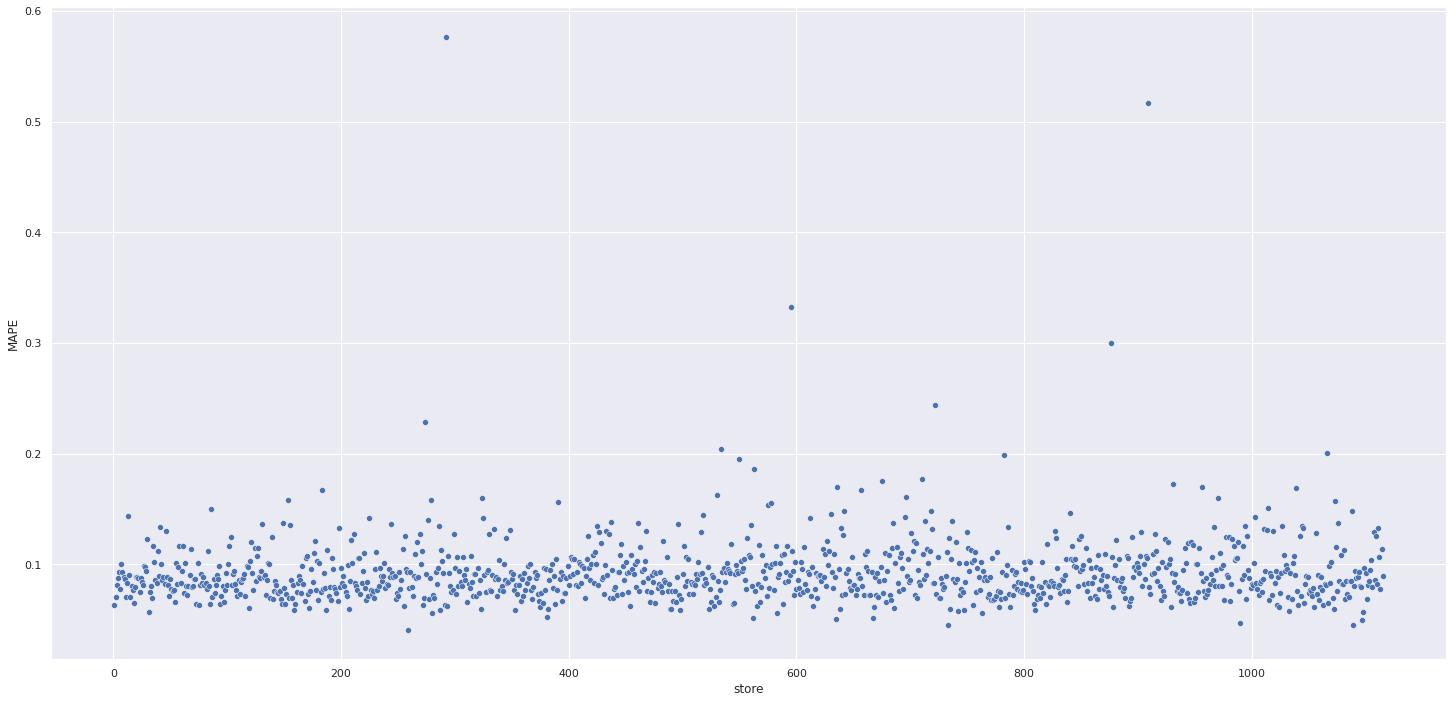

In [85]:
sns.scatterplot(x='store', y='MAPE', data= df9_2);

## 9.2 Total Performance

In [86]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x)).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df9_3['Values'] =  df9_3['Values'].map('USD{:,.2f}'.format)

In [87]:
df9_3.head()

,Scenario,Values
0,predictions,"USD283,911,040.00"
1,worst_scenario,"USD283,198,772.45"
2,best_scenario,"USD284,623,264.03"


## 9.3 Total Performance Machine Learning Model

In [88]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

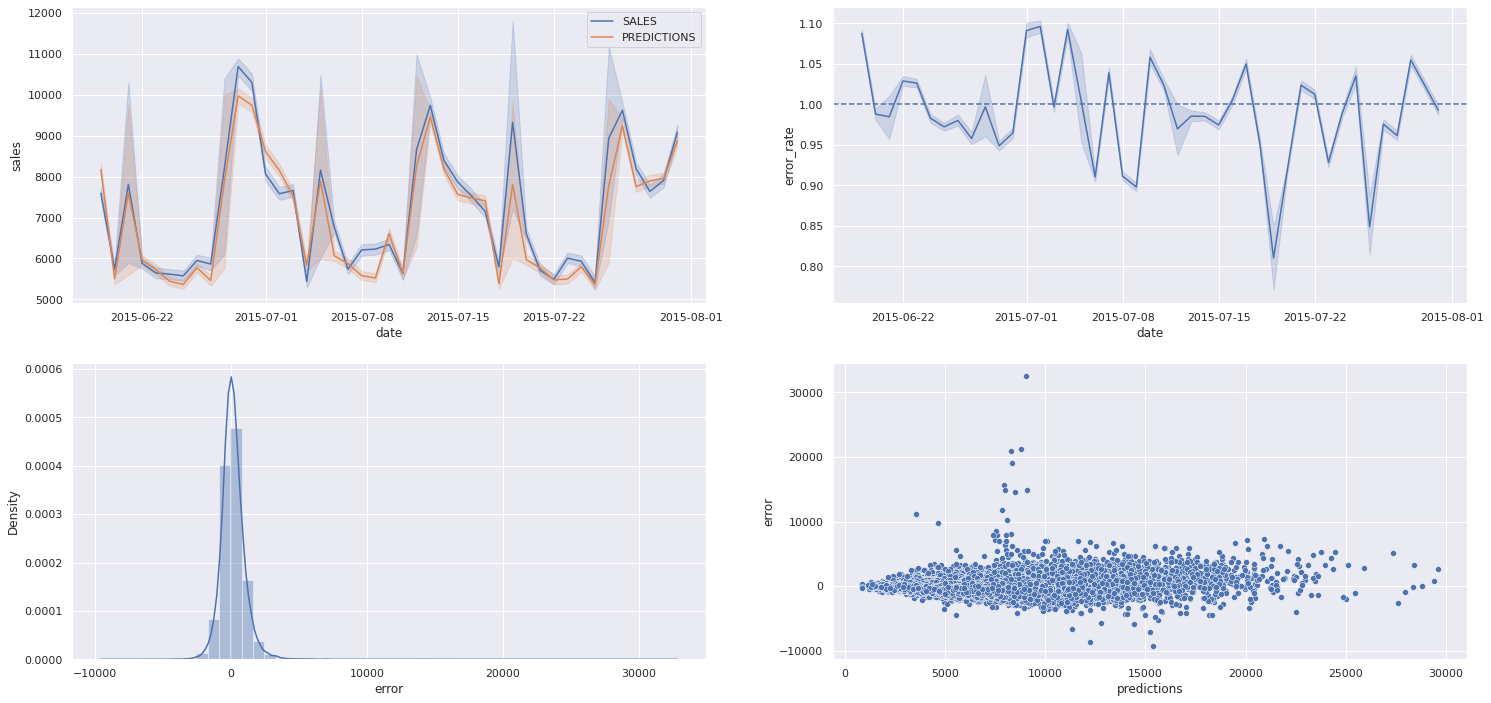

In [89]:
import matplotlib.pyplot as plt

plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0 Model Deploy to Production

In [13]:
pickle.dump( model_xgb_tuned, open('/home/andre/Documents/projects/rossmann/model/model_rossmann.pkl', 'wb'))

NameError: name 'model_xgb_tuned' is not defined

## 10.1 Rossmann Class

In [14]:
import pandas as pd 
import inflection 
import math 
import datetime 
import pickle
import numpy as np


class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler   = pickle.load(open('/home/andre/Documents/projects/rossmann/parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('/home/andre/Documents/projects/rossmann/parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('/home/andre/Documents/projects/rossmann/parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   =  pickle.load(open('/home/andre/Documents/projects/rossmann/parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open('/home/andre/Documents/projects/rossmann/parameter/store_type_scaler.pkl', 'rb'))

    
    def data_cleaning(self, df1):

        ## **1.1. Renomeando colunas** 
        #armazenando as colunas em uma variável 
        columns_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                       'CompetitionDistance', 'CompetitionOpenSinceMonth',
                       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                       'Promo2SinceYear', 'PromoInterval']


        #alterando o formato dos nomes das colunas 
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase,columns_old))
        df1.columns = cols_new


        ## **1.3. TIPO DOS DADOS**
        #alterando o tipo da coluna 'date' para o formato datetime
        df1['date'] = pd.to_datetime(df1['date'])


        ## **1.5. Preenchendo dados NA(Vazios)**
        df1['competition_distance'].max()

        #tratando as colunas com valores vazios
        #competition_distance
        df1['competition_distance'].fillna(200000.0, inplace=True)

        #competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 


        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)  


        #promo2_since_week  
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 


        #promo2_since_year  
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 


        #promo_interval   
        df1['promo_interval'].fillna(0, inplace=True)           


        #gerando nova coluna no df 
        month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

        #criando uma nova coluna no df 
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        #criando uma nova coluna no df
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## **1.6. Alterando Tipos**  
        #alterando as colunas para o tipo INT
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)     
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int) 
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 
        
        return df1
    
    def feature_engineer(self, df2): 

        #year 
        df2['year'] = df2['date'].dt.year

        #month 
        df2['month'] = df2['date'].dt.month

        #day 
        df2['day'] = df2['date'].dt.day

        #week of year 
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week 
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since 
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] ) /30).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment 
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        #  **3.0. FILTAGREM DE VARIAVEIS**
        ## **3.1. Filtragem de linha**

        #FILTRAGEM DE LINHAS 
        df2 = df2[df2['open'] != 0]

        ## 3.2. **Seleção das Colunas**
        # Selecionando colunas para excluir
        cols_drop = ['open', 'promo_interval', 'month_map']

        cols_drop = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
    
        ## **5.2 Reescalação**
        #VARIÁVEIS NÃO CÍCLICAS 

        #competition_distance 
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month 
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)



        ### **5.3.1 Encoding**
        #state_holiday - One Hot Encoder(Dumming Encoding)
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - Label Encoder
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        

        #assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### **5.3.2 Transformação da variável resposta**
        #reescalando a variável resposta 
        #df5['sales'] = np.log1p(df5['sales'])

        ### **5.3.3. Transformacao de Natureza**

        #VARIÁVEIS CÍCLICAS 

        #aplicando o seno e cosseno nas variáveis cíclicas, para fazer a transformação dos dados de categóricos(letras) para inteiros 

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2. * np.pi /30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2. * np.pi /30)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2. * np.pi /12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2. * np.pi /12)))

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi /7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi /7)))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi /52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi /52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                               'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                               'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin',
                               'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        # predição 
        pred = model.predict(test_data)
        
        # unindo a predição com os dados originais 
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [15]:
import pandas as pd 
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
import pickle

#  carregando modelo 
model = pickle.load(open('/home/andre/Documents/projects/rossmann/model/model_rossmann.pkl', 'rb'))

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    print(test_json)
    
    if test_json: #tem dados
        if isinstance(test_json, dict): # exemplo único 
            test_raw = pd.Dataframe(test_json, index=[0])
        
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        # instanciando classe do rossmann 
        pipeline = Rossmann()
        
        # limpeza dos dados
        df1 = pipeline.data_cleaning(test_raw)
        
        # atributo dos dados 
        df2 = pipeline.feature_engineer(df1)
        
        # preparação dos dados
        df3 = pipeline.data_preparation(df2)
        
        # predição dos dados
        df_response = pipeline.get_prediction(model, test_raw, df3)
                               
        
        return test_json
        #return df_response
    
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('127.0.0.1')

ModuleNotFoundError: No module named 'rossmann'

In [98]:
rossmann_predict()

NameError: name 'rossmann_predict' is not defined

## 10.3 API Tester

In [16]:
import requests
import json

In [17]:
# carregando o dataset de teste
df10 = pd.read_csv('/home/andre/Documents/projects/rossmann/data/test.csv')

In [18]:
# unindo os datasets
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# escolhendo uma loja específica 
#df_test = df_test[df_test['Store'] == 27] 
df_test = df_test[df_test['Store'].isin([24, 12, 22])] 


# excluindo os dias em que as lojas estão fechadas 
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]

# excluindo a coluna 'ID'
df_test = df_test.drop('Id', axis=1)

In [19]:
# convertendo o Datafram em Json
data = json.dumps(df_test.to_dict(orient='records'))

In [20]:
# chamando a API 
url = 'http://127.0.0.1:5000/rossmann/predict'
#url = 'https://predict-time-series.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data= data, headers= header)
print('Status code: {}'.format(r.status_code))

Status code: 200


In [21]:
# transformando os dados JSON em um DataFrame novamente 
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [22]:
# agrupando a predição por loja 
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell USD:{:,.2f} in the next 6 weeks!'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store number 12 will sell USD:263,374.61 in the next 6 weeks!
Store number 22 will sell USD:160,917.60 in the next 6 weeks!
Store number 24 will sell USD:293,501.71 in the next 6 weeks!
